In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import threading


In [2]:
# IMDb dataset (50,000 reviews, labeled positive/negative)
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=10000)

# Pad sequences for equal length
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=200)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=200)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
def create_model():
    model = keras.Sequential([
        layers.Embedding(input_dim=10000, output_dim=64, input_length=200),
        layers.LSTM(64),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [4]:
#Part I – Data Parallelism (CUDA)
with tf.device('/GPU:0'):   # Forces training on GPU
    model = create_model()
    history = model.fit(x_train, y_train, batch_size=512, epochs=2, validation_split=0.2)


Epoch 1/2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6049 - loss: 0.6700 - val_accuracy: 0.7936 - val_loss: 0.4562
Epoch 2/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8343 - loss: 0.3852 - val_accuracy: 0.8442 - val_loss: 0.3669


In [5]:
#Part II – Task Parallelism (Multi-threading)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd




def train_sentiment_model():
    with tf.device('/GPU:0'):
        model = create_model()
        model.fit(x_train, y_train, batch_size=512, epochs=2, validation_split=0.2)
        print("Sentiment model training completed")
######################################################################3
def load_credit_approval_dataset():
    data = fetch_openml("credit-g", version=1, as_frame=True)
    df = data.frame
    return df

def fraud_preprocessing_task():
    # Load dataset
    df = load_credit_approval_dataset()
    print("Original dataset shape:", df.shape)
    print("Class distribution:\n", df['class'].value_counts(), "\n")

    # Separate features and target
    X = df.drop("class", axis=1)
    y = (df["class"] == "bad").astype(int)  # encode: bad=1 (fraud), good=0

    # Identify categorical vs numeric
    categorical_cols = X.select_dtypes(include=["category", "object"]).columns
    numeric_cols = X.select_dtypes(exclude=["category", "object"]).columns

    # Preprocessing: OneHot for categorical, StandardScaler for numeric
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
        ]
    )

    # Pipeline
    pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
    X_processed = pipeline.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y, test_size=0.2, stratify=y, random_state=42
    )

    print("After preprocessing:")
    print("Train set:", X_train.shape, " Test set:", X_test.shape)
    print("Fraud cases in train:", sum(y_train), " / in test:", sum(y_test))

    return X_train, X_test, y_train, y_test
########################################################3
# Run tasks in parallel using threads
t1 = threading.Thread(target=train_sentiment_model)
t2 = threading.Thread(target=fraud_preprocessing_task)

t1.start()
t2.start()

t1.join()
t2.join()


Epoch 1/2
24/40 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5688 - loss: 0.6860Original dataset shape: (1000, 21)
Class distribution:
 class
good    700
bad     300
Name: count, dtype: int64 

26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5727 - loss: 0.6845After preprocessing:
Train set: (800, 61)  Test set: (200, 61)
Fraud cases in train: 240  / in test: 60
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5975 - loss: 0.6713 - val_accuracy: 0.7756 - val_loss: 0.4997
Epoch 2/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8168 - loss: 0.4185 - val_accuracy: 0.8430 - val_loss: 0.3616
Sentiment model training completed


Original dataset shape: (1000, 21)
Class distribution:
 class
good    700
bad     300
Name: count, dtype: int64 

After preprocessing:
Train set: (800, 61)  Test set: (200, 61)
Fraud cases in train: 240  / in test: 60
Epoch 1/2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5684 - loss: 0.6715 - val_accuracy: 0.7988 - val_loss: 0.4448
Epoch 2/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8486 - loss: 0.3638 - val_accuracy: 0.8578 - val_loss: 0.3374
Sentiment model training completed


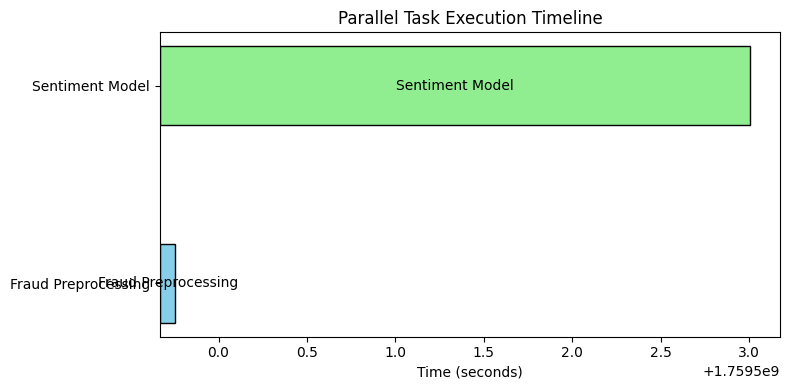

In [6]:
import threading
import time
import matplotlib.pyplot as plt

# --- Your Tasks ---
def train_sentiment_model():
    start = time.time()
    with tf.device('/GPU:0'):
        model = create_model()
        model.fit(x_train, y_train, batch_size=512, epochs=2, validation_split=0.2)
        print("Sentiment model training completed")
    end = time.time()
    task_times["Sentiment Model"] = (start, end)

def load_credit_approval_dataset():
    data = fetch_openml("credit-g", version=1, as_frame=True)
    df = data.frame
    return df

def fraud_preprocessing_task():
    start = time.time()
    # Load dataset
    df = load_credit_approval_dataset()
    print("Original dataset shape:", df.shape)
    print("Class distribution:\n", df['class'].value_counts(), "\n")

    # Separate features and target
    X = df.drop("class", axis=1)
    y = (df["class"] == "bad").astype(int)  # encode: bad=1 (fraud), good=0

    # Identify categorical vs numeric
    categorical_cols = X.select_dtypes(include=["category", "object"]).columns
    numeric_cols = X.select_dtypes(exclude=["category", "object"]).columns

    # Preprocessing: OneHot for categorical, StandardScaler for numeric
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
        ]
    )

    # Pipeline
    pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
    X_processed = pipeline.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y, test_size=0.2, stratify=y, random_state=42
    )

    print("After preprocessing:")
    print("Train set:", X_train.shape, " Test set:", X_test.shape)
    print("Fraud cases in train:", sum(y_train), " / in test:", sum(y_test))
    end = time.time()
    task_times["Fraud Preprocessing"] = (start, end)

    return X_train, X_test, y_train, y_test


# Dictionary to store execution times
task_times = {}

# Run threads
t1 = threading.Thread(target=train_sentiment_model)
t2 = threading.Thread(target=fraud_preprocessing_task)

t1.start()
t2.start()
t1.join()
t2.join()

# --- Plot Gantt Chart ---
fig, ax = plt.subplots(figsize=(8,4))

colors = ["skyblue", "lightgreen"]
for i, (task, (start, end)) in enumerate(task_times.items()):
    ax.barh(y=i, width=end-start, left=start, height=0.4, color=colors[i], edgecolor="black")
    ax.text((start+end)/2, i, task, ha="center", va="center", fontsize=10, color="black")

ax.set_yticks([0, 1])
ax.set_yticklabels(list(task_times.keys()))
ax.set_xlabel("Time (seconds)")
ax.set_title("Parallel Task Execution Timeline")
plt.tight_layout()
plt.show()
